# Directors Analysis Notebook

Directors baby!! This notebook mainly focuses on these main analysis:
1. Basic statistics about directors and their movies/genres.
2. Genres analysis based on directors.
3. Comparing directors.

In [58]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

notebook_dir = Path().resolve()
base_path = os.path.abspath(notebook_dir.parent.parent)
sys.path.append(base_path)
from src.data_utils import *

In [59]:
data_path = os.path.join(base_path, "data", "data_final")
csv_path = os.path.join(data_path, "final_dataset.csv")

In [60]:
df = load_final_data_with_embeddings(csv_path, data_path, verbose=False)

In [61]:
df = df.filter(
    [
        "movie_id",
        "directors",
        "title",
        "popularity",
        "vote_average",
        "vote_count",
        "plot",
        "year",
        "embedding",
        "new_genre",
    ]
)

In [62]:
with open("../cluster_to_genre_mapping_01122025.json", "r") as f:
    genre_fix_mapping = json.load(f)

In [63]:
df = df[(df["new_genre"] != "Unknown") & (df["new_genre"].notna())].reset_index(drop=True)

In [64]:
df["new_genre"] = df["new_genre"].apply(lambda x: [genre_fix_mapping[i] for i in x.split("|")])

# Basic Statistics about Directors

In [65]:
# Number of non null directors
print("Number of rows with directors:")
print(df[(df.directors.notna()) & (df.directors!= "")].shape[0])

Number of rows with directors:
76695


In [66]:
df = df[(df.directors.notna()) & (df.directors!= "")].reset_index(drop=True)

Problem 1: We have directors whose name has "," in it, which messes up our splitting of multiple directors.

In [67]:
# Solution for now: split by "," and discard those with < 5 characters, 
# this should remove all "jr.", "sr." 
# and should technically not remove first names
df["directors"] = df["directors"].apply(lambda x: [i.strip() for i in x.split(",")])

In [68]:
directors_df = df.explode("directors", ignore_index=True)

In [69]:
directors_df = directors_df[directors_df.directors.apply(len)>=4].reset_index(drop=True)

Problem 2: some directors are wikipedia IDs instead of names.

In [70]:
import re

def is_wiki_id(director: str) -> bool:
    pattern = re.compile(r"^Q\d+$")
    return bool(pattern.match(director))

In [71]:
# Vibecoded

import requests
from typing import Optional

WIKIDATA_API = "https://www.wikidata.org/w/api.php"
HEADERS = {"User-Agent": "python-wikidata-qid-lookup/1.0 (your-email@example.com)"}

def get_enwiki_title_from_qid(qid: str, timeout: float = 5.0) -> Optional[str]:
    """
    Return the en.wikipedia title for a Wikidata QID (e.g. "Q42"), or None if missing.
    """
    params = {
        "action": "wbgetentities",
        "ids": qid,
        "props": "sitelinks",   # or "sitelinks/urls" if you want URLs
        "format": "json"
    }

    try:
        resp = requests.get(WIKIDATA_API, params=params, headers=HEADERS, timeout=timeout)
        resp.raise_for_status()
        data = resp.json()

        entities = data.get("entities", {})
        entity = entities.get(qid)
        if not entity:
            return None

        sitelinks = entity.get("sitelinks", {})
        en = sitelinks.get("enwiki")
        if not en:
            return None

        # If you used props=sitelinks/urls you can get en['url'] instead.
        return en.get("title")
    except (requests.RequestException, ValueError):
        return None


# Examples
if __name__ == "__main__":
    print(get_enwiki_title_from_qid("Q42"))     # -> "Douglas Adams" (expected)
    print(get_enwiki_title_from_qid("Q1"))      # -> title for Q1 if enwiki sitelink exists
    print(get_enwiki_title_from_qid("Q999999999"))  # -> None (likely no such item)


Douglas Adams
Universe
None


In [72]:
directors_df.loc[directors_df.directors.apply(is_wiki_id), "directors"] = directors_df.loc[directors_df.directors.apply(is_wiki_id), "directors"].apply(get_enwiki_title_from_qid)

In [73]:
# New number of null directors, drop them
directors_df[directors_df.directors.isna()].shape

(52, 10)

In [74]:
directors_df = directors_df[directors_df.directors.notna()].reset_index(drop=True)

In [75]:
print(directors_df.shape)

(81355, 10)


## Number of movies per director

In [76]:
directors_total_num_movies = directors_df.groupby("directors").movie_id.nunique().reset_index(name="num_movies").sort_values(
    by="num_movies", ascending=False
)
directors_total_num_movies.head(20)

,directors,num_movies
13359,Jules White,103
27159,William Beaudine,96
15301,Lesley Selander,92
17501,Michael Curtiz,90
15351,Lew Landers,86
23067,Sam Newfield,85
13016,Joseph Kane,85
21800,Richard Thorpe,82
6900,Edward L. Cahn,80
25142,Takashi Miike,80


In [77]:
directors_total_num_movies["num_movies"].describe()

count    28078.000000
mean         2.897429
std          4.948251
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        103.000000
Name: num_movies, dtype: float64

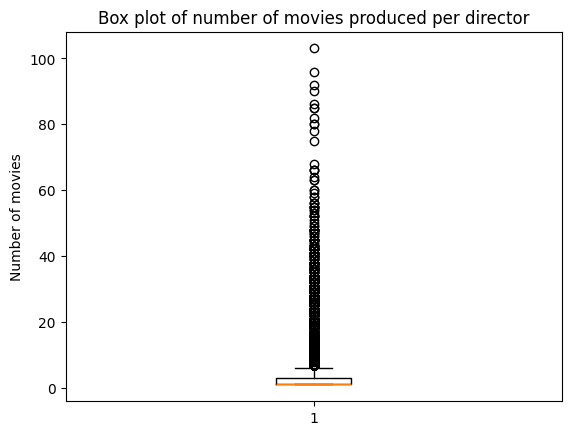

In [78]:
# Box plot
plt.figure()
plt.boxplot(directors_total_num_movies["num_movies"])
plt.title("Box plot of number of movies produced per director")
plt.ylabel("Number of movies")
plt.show();

We see the describe() function showing that most directors only directed 2 movies. Maybe we can focus on directors who directed more than a certain number of movies for our analysis.

Let us just focus on directors who directed more than 5 movies for now.

In [79]:
directors_total_num_movies[directors_total_num_movies.num_movies >= 5]

,directors,num_movies
13359,Jules White,103
27159,William Beaudine,96
15301,Lesley Selander,92
17501,Michael Curtiz,90
15351,Lew Landers,86
...,...,...
8460,Gene Nelson,5
19449,Osvaldo Civirani,5
25171,Takeshi Yokoi,5
17753,Michael Tiddes,5


In [80]:
valid_directors = directors_total_num_movies[directors_total_num_movies.num_movies >= 5].directors.tolist()

In [81]:
directors_df = directors_df[directors_df.directors.isin(valid_directors)].reset_index(drop=True)

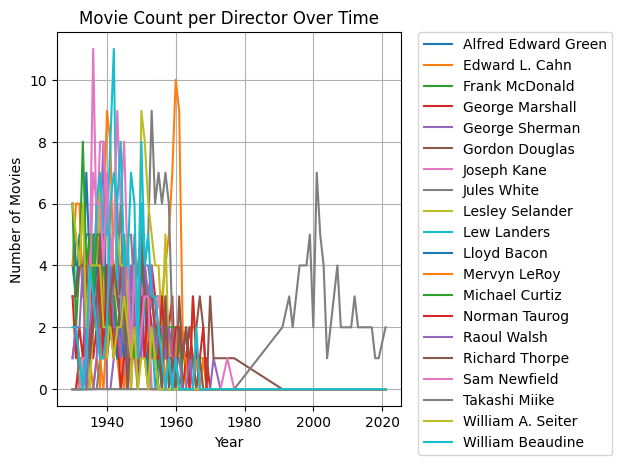

In [83]:
## Plot all director's number of movies over the years

top_20_directors_by_count = directors_total_num_movies.head(20).directors.tolist()

# Group by director and year, count movies
movies_per_year = (
    directors_df[directors_df.directors.isin(top_20_directors_by_count)].groupby(["directors", "year"])
      .size()                   # count rows per group
      .reset_index(name="count")
)

pivot = movies_per_year.pivot(index="year", columns="directors", values="count").fillna(0)

ax = pivot.plot()
ax.set_xlabel("Year")
ax.set_ylabel("Number of Movies")
ax.set_title("Movie Count per Director Over Time")
ax.grid(True)

# Move legend to the right, outside the plot
ax.legend(
    bbox_to_anchor=(1.05, 1),   # x, y anchor (to the right of the axes)
    loc="upper left",
    borderaxespad=0
)

plt.tight_layout()
plt.show()


In [52]:
# Fucking useless 
# Maybe is there any interest in prioritizing the newer years? Maybe some sort of higher weights for the recent years?

# Inter director cosine similarity

In [87]:
from scipy.spatial.distance import cdist
from tqdm import tqdm

In [88]:
unique_directors = directors_df.directors.unique().tolist()
plot_directors = []
medians = []
lowers = []
uppers = []
counts = []
for director in tqdm(unique_directors, total=len(unique_directors)):
    director_sub_df = directors_df[directors_df.directors==director]
    if len(director_sub_df) <= 3:
        continue
    director_embedding = np.stack(director_sub_df.embedding.tolist())
    director_pairwise = cdist(director_embedding, director_embedding, metric="cosine")
    vals = director_pairwise[np.triu_indices_from(director_pairwise, k=1)]
    quantiles = np.quantile(vals, q=[0.25, 0.5, 0.75])
    median = quantiles[1]
    lower = quantiles[0]
    upper = quantiles[2]
    plot_directors.append(director)
    medians.append(median)
    lowers.append(lower)
    uppers.append(upper)
    counts.append(director_sub_df.shape[0])

100%|██████████| 3978/3978 [00:05<00:00, 788.64it/s]


In [89]:
directors_distance_df = pd.DataFrame({"directors": plot_directors, "quantile_25": lowers, "median": medians, "quantile_75": uppers, "num_movies": counts})

In [90]:
directors_distance_df.sort_values(by="median").head(50)

,directors,quantile_25,median,quantile_75,num_movies
1999,John Alan Schwartz,0.000000,0.000000,0.000000,6
3419,Kazuya Tsurumaki,0.152057,0.167266,0.443448,5
3877,Keishi Ōtomo,0.205802,0.222178,0.409638,6
2069,Tsutomu Shibayama,0.214538,0.226254,0.245599,11
2896,Lee Chang-dong,0.241122,0.263081,0.280709,5
3587,Rodolfo Riva Palacio Alatriste,0.239250,0.265482,0.292392,5
3588,Gabriel Riva Palacio Alatriste,0.239250,0.265482,0.292392,5
2045,Dušan Klein,0.241528,0.268212,0.295468,6
1958,Lasse Åberg,0.264684,0.284326,0.323621,5
1959,Peter Hald,0.264684,0.284326,0.323621,5


In [91]:
directors_df[directors_df.directors=="Dušan Klein"]

,movie_id,directors,title,popularity,vote_average,vote_count,plot,year,embedding,new_genre
22522,Q5918429,Dušan Klein,How the World Is Losing Poets,0.5701,5.625,12.0,"Štepán Šafránek, a high school student with po...",1982,"[-0.02719, 0.06015, -0.02805, -0.03537, 0.0044...","[romance, comedy]"
23804,Q5918075,Dušan Klein,How Poets Are Losing Their Illusions,0.7639,5.679,14.0,Friends and former small-town classmates Štěpá...,1985,"[-0.0235, 0.01933, -0.02701, -0.03748, -0.0167...","[romance, comedy]"
25208,Q5918080,Dušan Klein,How Poets Are Enjoying Their Lives,0.4465,5.950,10.0,After successfully completing his medical stud...,1988,"[-0.01628, 0.00973, -0.04004, -0.007225, -0.00...","[romance, comedy]"
27590,Q6429064,Dušan Klein,Konec básníků v Čechách,1.4285,5.000,7.0,"A few years after the Velvet Revolution, much ...",1993,"[-0.005844, 0.004116, -0.0287, 0.0211, -0.0159...","[romance, comedy]"
33712,Q6124405,Dušan Klein,Jak básníci neztrácejí naději,0.4441,4.500,6.0,"After the death of his mother, Štěpán, now in ...",2004,"[-0.02766, 0.03625, -0.0277, 0.002922, -0.0189...",[comedy]
41332,Q21034064,Dušan Klein,Jak básníci čekají na zázrak,0.5873,5.300,3.0,"Štěpán's wife, Anička, with whom he fell in lo...",2016,"[-0.0282, 0.01936, -0.02423, 0.00815, -0.02171...",[comedy]


In [92]:
directors_distance_df.sort_values(by="median", ascending=False).head(50)

,directors,quantile_25,median,quantile_75,num_movies
2151,Gorman Bechard,0.543272,0.597079,0.641429,8
215,Aubrey Scotto,0.561335,0.587161,0.614076,6
3879,Joseph J. Lawson,0.549068,0.581398,0.600561,5
234,Leni Riefenstahl,0.476672,0.573545,0.589820,6
2932,Mary McGuckian,0.537149,0.571843,0.589518,6
3514,Marshall Curry,0.495204,0.569939,0.639424,5
1968,Gabrielle Beaumont,0.498533,0.569738,0.596063,6
1705,Michael Rubbo,0.527987,0.564633,0.610355,6
3058,Zhang Yang,0.439481,0.564403,0.601551,5
291,Roy Mack,0.539602,0.564136,0.616659,6


# Genre analysis based on Directors

In [93]:
# For each valid director, what is the number of unique genres they have
valid_directors = directors_df[directors_df.directors.isin(valid_directors)].reset_index(drop=True)

In [94]:
new_genre_exploded = valid_directors.explode("new_genre")
new_genre_exploded.groupby("directors").new_genre.nunique().reset_index(
    name="unique_genre_count"
).sort_values(by="unique_genre_count", ascending=False).head(20)

,directors,unique_genre_count
3168,Robert Zemeckis,17
2465,Michael Curtiz,16
2383,Martin Scorsese,16
3162,Robert Stevenson,15
981,Ethan Coen,15
3212,Ron Howard,15
1393,Henry Levin,15
1726,John Boorman,15
3057,Richard Fleischer,15
1388,Henry Hathaway,15


Very cool to see famous directors such as Martin Scorsease, Peter Jackson and Ridley Scott here.

# Cosine Distance from most average movie

- Who are the directors that directed the most average movie in each genre?
- How similar/dissimilar are directors movies to the most average movie in each genre?

In [95]:
from src.analysis.math_functions.cosine_distance_util import find_nearest_and_furthest_medoid

In [96]:
from tqdm import tqdm

In [97]:
# Split years by decades
# Find most average movie per decade
# Plot
decades = list(range(directors_df.year.min(), directors_df.year.max(), 10))
most_ave_movie_per_decade = []
least_ave_movie_per_decade = []
for decade in tqdm(decades, total=len(decades)):
    sim_ind, dissim_ind = find_nearest_and_furthest_medoid(
        np.stack(directors_df[(directors_df.year >= decade) & (directors_df.year <= decade + 10)].embedding.tolist())
    )
    most_ave_movie_per_decade.append(sim_ind)
    least_ave_movie_per_decade.append(dissim_ind)

100%|██████████| 10/10 [03:29<00:00, 20.93s/it]


In [98]:
len(most_ave_movie_per_decade), len(least_ave_movie_per_decade)

(10, 10)

In [99]:
sim_movie_id = []
dissim_movie_id = []
for i, decade in tqdm(enumerate(decades), total=len(decades)):
    tmp_df = directors_df[(directors_df.year >= decade) & (directors_df.year <= decade + 10)]
    sim_movie_id.append(tmp_df.iloc[most_ave_movie_per_decade[i]].movie_id)
    dissim_movie_id.append(tmp_df.iloc[least_ave_movie_per_decade[i]].movie_id)

100%|██████████| 10/10 [00:00<00:00, 1784.43it/s]


In [100]:
# Now use the latest decade's most similar movie as the anchor.
# Calculate cosine distance of each decade's ave movie to this anchor
# Plot
from scipy.spatial.distance import cosine

anchor_embedding = directors_df[directors_df.movie_id == sim_movie_id[-1]].iloc[0].embedding
cos_dist_of_dissim_movies = [
    float(cosine(directors_df[directors_df.movie_id == i].iloc[0].embedding, anchor_embedding))
    for i in sim_movie_id
]

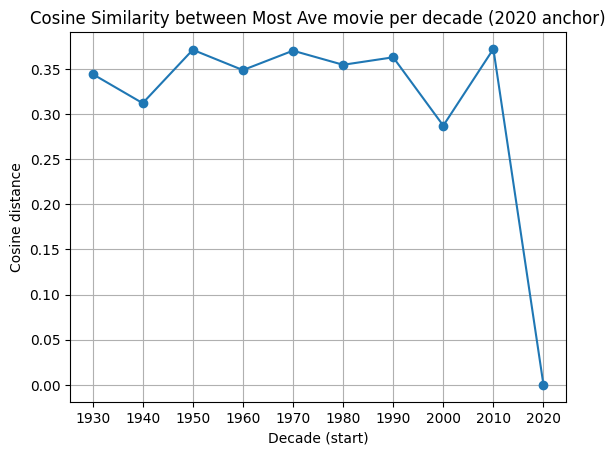

In [101]:
plt.figure()
plt.plot(decades, cos_dist_of_dissim_movies, marker="o")
plt.grid(True)
plt.xticks(decades)
plt.title("Cosine Similarity between Most Ave movie per decade (2020 anchor)")
plt.xlabel("Decade (start)")
plt.ylabel("Cosine distance")
plt.show();

## Multidimensional Scaling (MDS) Visualization

Use the pairwise cosine distances and dimensionality reduction using MDS to visualize any trends between movies.

In [102]:
scifi_movies = df[df.new_genre.apply(lambda x: "fantasy and scifi" in x)].reset_index(drop=True)

In [103]:
from scipy.spatial.distance import cdist

embeddings = np.stack(scifi_movies.embedding.tolist())
pairwise_cos_distance = cdist(embeddings, embeddings, metric="cosine")

In [104]:
pairwise_cos_distance.shape

(6565, 6565)

In [105]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

In [106]:
pca = PCA(n_components=2, random_state=42)
scifi_pca = pca.fit_transform(pairwise_cos_distance)

In [107]:
pca.explained_variance_ratio_

array([0.44148538, 0.09149684])

In [108]:
scifi_movies["pca1"] = scifi_pca[:, 0]
scifi_movies["pca2"] = scifi_pca[:, 1]

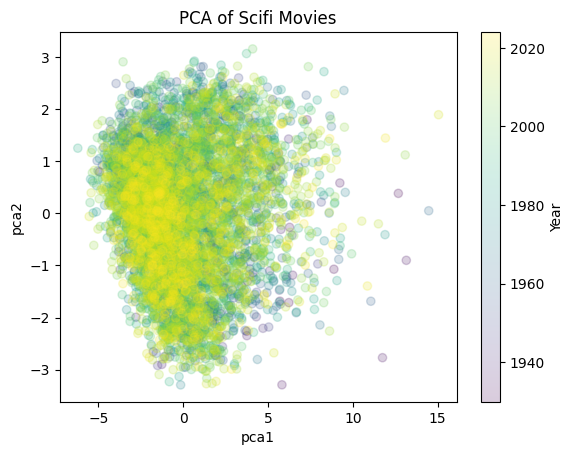

In [168]:
plt.figure()
plt.scatter(scifi_movies.pca1, scifi_movies.pca2, c=scifi_movies.year, alpha=0.2)
plt.colorbar(label='Year')
plt.title("PCA of Scifi Movies")
plt.xlabel("pca1")
plt.ylabel("pca2")
plt.show();

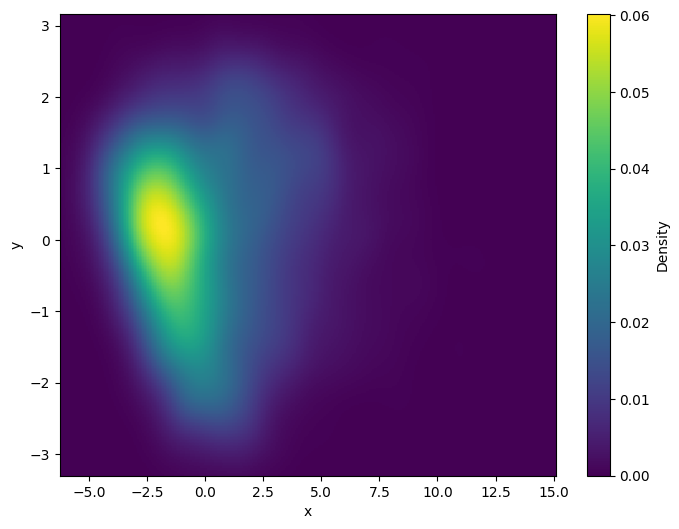

In [110]:
from scipy.stats import gaussian_kde

x = scifi_movies['pca1'].values
y = scifi_movies['pca2'].values

kde = gaussian_kde([x, y])
X, Y = np.meshgrid(
    np.linspace(x.min(), x.max(), 300),
    np.linspace(y.min(), y.max(), 300),
)
Z = kde([X.ravel(), Y.ravel()]).reshape(X.shape)

plt.figure(figsize=(8,6))
plt.pcolormesh(X, Y, Z, shading='auto')
plt.colorbar(label='Density')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

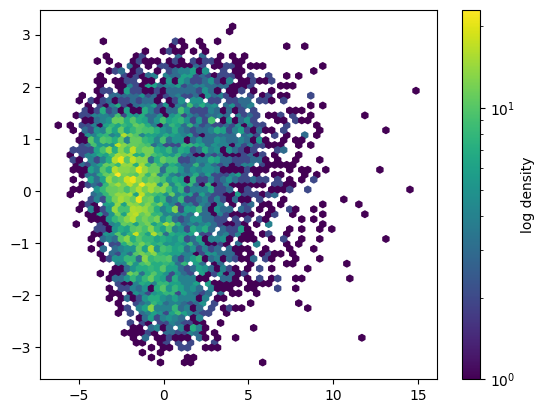

In [111]:
plt.hexbin(scifi_movies['pca1'], scifi_movies['pca2'], gridsize=60, bins='log')
plt.colorbar(label='log density')

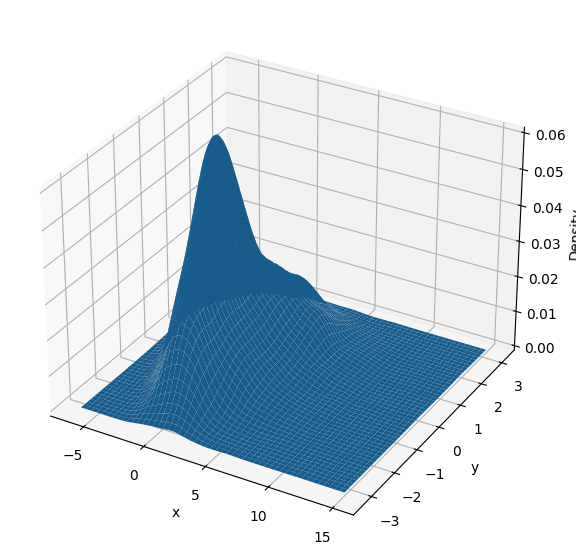

In [112]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Density')
plt.show()

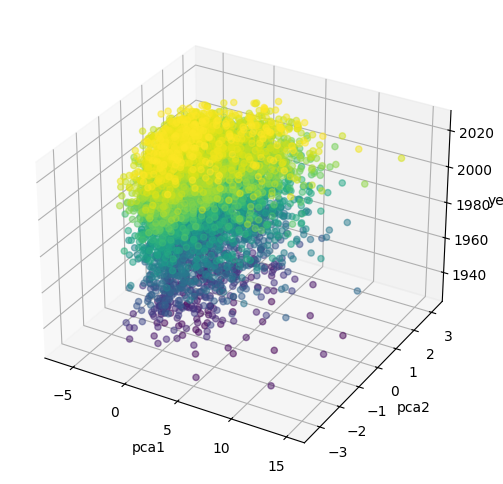

In [158]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    scifi_movies['pca1'], 
    scifi_movies['pca2'], 
    scifi_movies['year'].astype(int), 
    c=scifi_movies['year'],    # optional: color by year as well
    alpha=0.5
)

ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_zlabel('year')

plt.show()

In [114]:
mds = MDS(n_components=2, n_init=1)

In [115]:
scifi_mds = mds.fit_transform(pairwise_cos_distance)

In [116]:
scifi_movies["mds1"] = scifi_mds[:, 0]
scifi_movies["mds2"] = scifi_mds[:, 1]

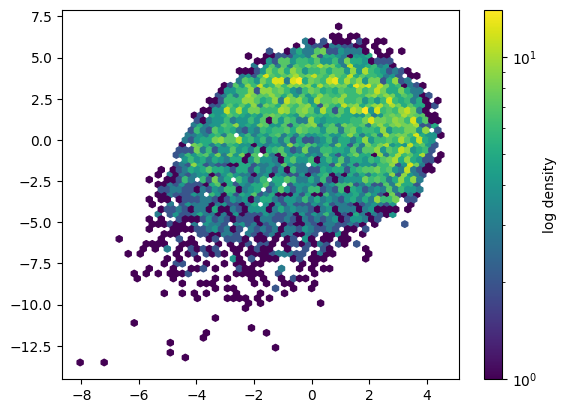

In [117]:
plt.hexbin(scifi_movies['mds1'], scifi_movies['mds2'], gridsize=60, bins='log')
plt.colorbar(label='log density');

In [118]:
# Try sampling random movies and plot via pca
random_sample = df.sample(10000, random_state=42)
emb_10k = np.stack(random_sample.embedding.tolist())

In [119]:
sample_pairwise = cdist(emb_10k, emb_10k, metric="cosine")

In [120]:
sample_pairwise.shape

(10000, 10000)

In [121]:
pca = PCA(n_components=2, random_state=42)
emb_10k_pca = pca.fit_transform(sample_pairwise)

In [122]:
random_sample["pca1"] = emb_10k_pca[:, 0]
random_sample["pca2"] = emb_10k_pca[:, 1]

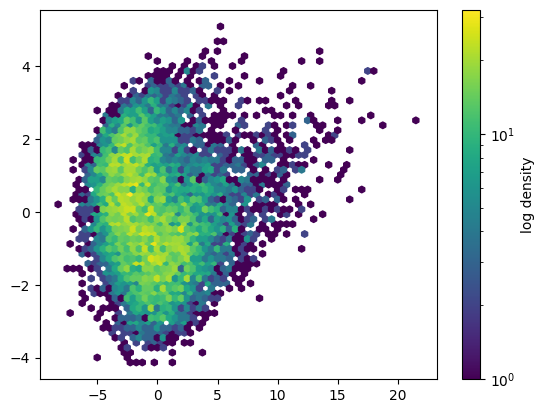

In [123]:
plt.hexbin(random_sample['pca1'], random_sample['pca2'], gridsize=60, bins='log')
plt.colorbar(label='log density')

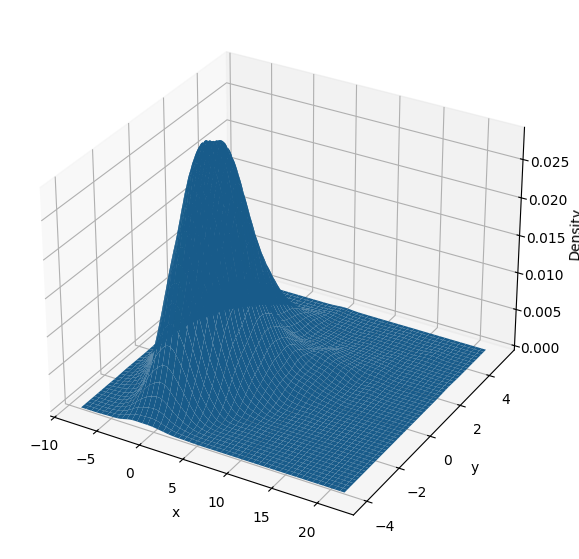

In [124]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

x = random_sample['pca1'].values
y = random_sample['pca2'].values

kde = gaussian_kde([x, y])
X, Y = np.meshgrid(
    np.linspace(x.min(), x.max(), 300),
    np.linspace(y.min(), y.max(), 300),
)
Z = kde([X.ravel(), Y.ravel()]).reshape(X.shape)

ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Density')
plt.show()

In [125]:
sample_pairwise.min(), sample_pairwise.max()

(np.float64(0.0), np.float64(0.8802531248395301))

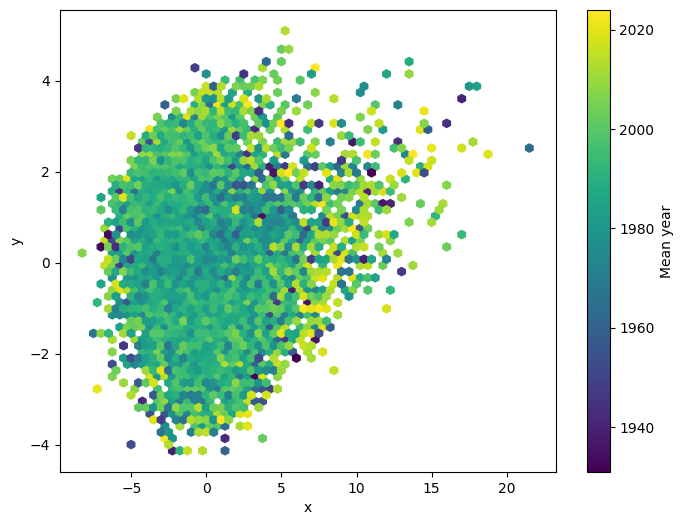

In [126]:
plt.figure(figsize=(8,6))
plt.hexbin(
    random_sample['pca1'], random_sample['pca2'],
    C=random_sample['year'],              # this is the value to aggregate
    reduce_C_function=np.mean, # compute average year per bin
    gridsize=60
)
plt.colorbar(label='Mean year')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [127]:
plt.figure(figsize=(8,6))

# Create grid
xi = np.linspace(random_sample['pca1'].min(), random_sample['pca1'].max(), 200)
yi = np.linspace(random_sample['pca2'].min(), random_sample['pca2'].max(), 200)
Xi, Yi = np.meshgrid(xi, yi)

# Digitize into grid
H = np.zeros_like(Xi)
CNT = np.zeros_like(Xi)

for (xx, yy, yr) in zip(random_sample['pca1'], random_sample['pca2'], random_sample['year']):
    ix = np.searchsorted(xi, xx) - 1
    iy = np.searchsorted(yi, yy) - 1
    if 0 <= ix < H.shape[1] and 0 <= iy < H.shape[0]:
        H[iy, ix] += yr
        CNT[iy, ix] += 1

Z = np.where(CNT > 0, H/CNT, np.nan)   # mean year per cell
ax.plot_surface(Xi, Yi, Z)
plt.show();

<Figure size 800x600 with 0 Axes>

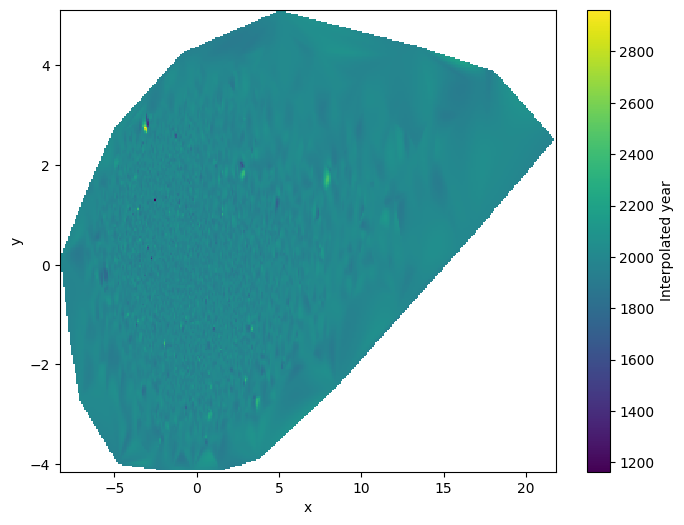

In [128]:
from scipy.interpolate import griddata
x = random_sample['pca1'].values
y = random_sample['pca2'].values
z = random_sample['year'].values

xi = np.linspace(x.min(), x.max(), 300)
yi = np.linspace(y.min(), y.max(), 300)
Xi, Yi = np.meshgrid(xi, yi)

Zi = griddata((x, y), z, (Xi, Yi), method='cubic')

plt.figure(figsize=(8,6))
plt.pcolormesh(Xi, Yi, Zi, shading='auto')
plt.colorbar(label='Interpolated year')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [129]:
# Try to sample first and second last decade, see if there is distance between them
first_decade = df[(df.year.astype(int) >= 1930) & (df.year.astype(int) <= 1939)].sample(2000, random_state=42)
first_decade["decade"] = "first"
first_decade.shape

(2000, 11)

In [130]:
second_last_decade = df[(df.year.astype(int) >= 2010) & (df.year.astype(int) <= 2019)].sample(2000, random_state=42)
second_last_decade["decade"] = "second_last"
second_last_decade.shape

(2000, 11)

In [131]:
decade_df = pd.concat([first_decade, second_last_decade], ignore_index=True)

In [132]:
decade_embeddings = np.stack(decade_df.embedding.tolist())

In [133]:
decade_pairwise = cdist(decade_embeddings, decade_embeddings, metric="cosine")

In [134]:
pca = PCA(n_components=2, random_state=42)
decade_pca = pca.fit_transform(decade_pairwise)

In [135]:
decade_df["pca1"] = decade_pca[:, 0]
decade_df["pca2"] = decade_pca[:, 1]

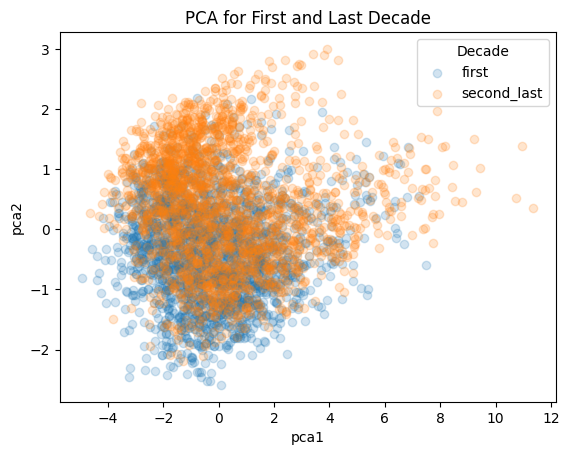

In [165]:
# Get unique decades and assign colors manually
decades = decade_df['decade'].unique()
colors = ['tab:blue', 'tab:orange']   # two categories → two colors

color_map = dict(zip(decades, colors))

plt.figure()

for dec in decades:
    mask = decade_df['decade'] == dec
    plt.scatter(
        decade_df.loc[mask, 'pca1'],
        decade_df.loc[mask, 'pca2'],
        color=color_map[dec],
        alpha=0.2,
        label=str(dec)
    )

plt.title("PCA for First and Last Decade")
plt.xlabel("pca1")
plt.ylabel("pca2")
plt.legend(title='Decade')
plt.show()

In [137]:
# if I try mds
mds = MDS(n_components=2, n_init=1)
decade_mds = mds.fit_transform(decade_pairwise)

In [138]:
decade_df["mds1"] = decade_mds[:, 0]
decade_df["mds2"] = decade_mds[:, 1]

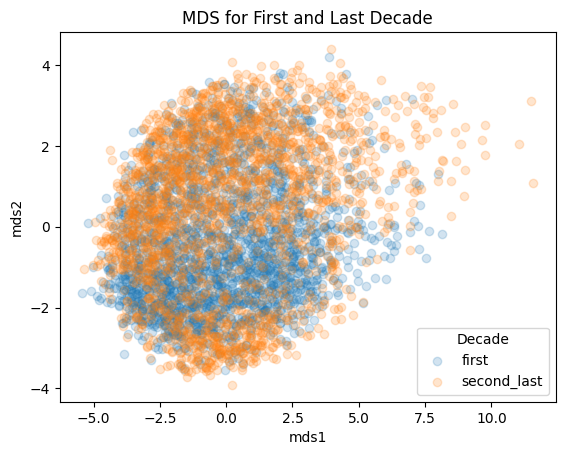

In [164]:
# cats = decade_df['decade'].astype('category')
# codes = cats.cat.codes

# plt.figure()
# plt.scatter(decade_df.mds1, decade_df.mds2, c=codes, cmap='tab10', alpha=0.2)
# plt.colorbar(label='Decade')
# plt.show();

decades = decade_df['decade'].unique()
colors = ['tab:blue', 'tab:orange']   # two categories → two colors

color_map = dict(zip(decades, colors))

plt.figure()

for dec in decades:
    mask = decade_df['decade'] == dec
    plt.scatter(
        decade_df.loc[mask, 'mds1'],
        decade_df.loc[mask, 'mds2'],
        color=color_map[dec],
        alpha=0.2,
        label=str(dec)
    )

plt.title("MDS for First and Last Decade")
plt.xlabel("mds1")
plt.ylabel("mds2")
plt.legend(title='Decade')
plt.show()

This further prompted more literature review: Why does the time seem to not affect the 2d visualization?

Answer: LLMs are not trained to be time aware.

1. BiTimeBert: https://arxiv.org/pdf/2204.13032
    - " they are incapable of utilizing temporal signals like document timestamp, despite temporal information being of key importance for many tasks such as ones that involve processing news articles."
2. Temporal Attention for Language Models: https://arxiv.org/pdf/2202.02093
3. Towards Effective Time-Aware Language Representations: https://arxiv.org/pdf/2406.01863v2
    
"The “static” nature of existing LMs makes them unaware of time, and in particular unware of language changes that occur over time. This prevents such models from adapting to time and generalizing temporally."
- Paul Röttger and Janet Pierrehumbert. 2021. Temporal adaptation of BERT and performance on downstream document classification: Insights from social media. In Findings of the Association for Computational Linguistics: EMNLP 2021, pages 2400–2412, Punta Cana, Dominican Republic.  Association for Computational Linguistics.
- Angeliki Lazaridou, Adhi Kuncoro, Elena Gribovskaya, Devang Agrawal, Adam Liska, Tayfun Terzi, Mai Gimenez, Cyprien de Masson d’Autume, Tomas Kocisky, Sebastian Ruder, et al. 2021. Mind the gap: Assessing temporal generalization in neural language models. Advances in Neural Information Processing Systems, 34.
- many more

In [140]:
# Plot showing average cosine distances between genres and average cos distance between decades.
# Experiment 1: same year, different genres
# Experiment 2: same genres, different years
from scipy.spatial.distance import cdist

In [141]:
from tqdm import tqdm
# Try it for all years:
yearly_lower_cos_dist = []
yearly_median_cos_dist = []
yearly_upper_cos_dist = []

for year in tqdm(df.year.unique().tolist(), total=df.year.nunique()):
    year_df = df[df.year==year]
    year_df_embeddings = np.stack(year_df.embedding.tolist())
    pairwise_year = cdist(year_df_embeddings, year_df_embeddings, metric="cosine")
    vals = pairwise_year[np.triu_indices_from(pairwise_year, k=1)]
    quantiles = np.quantile(vals, q=[0.25, 0.5, 0.75])
    median = quantiles[1]
    lower = quantiles[0]
    upper = quantiles[2]
    yearly_median_cos_dist.append(median)
    yearly_lower_cos_dist.append(lower)
    yearly_upper_cos_dist.append(upper)

100%|██████████| 95/95 [01:05<00:00,  1.44it/s]


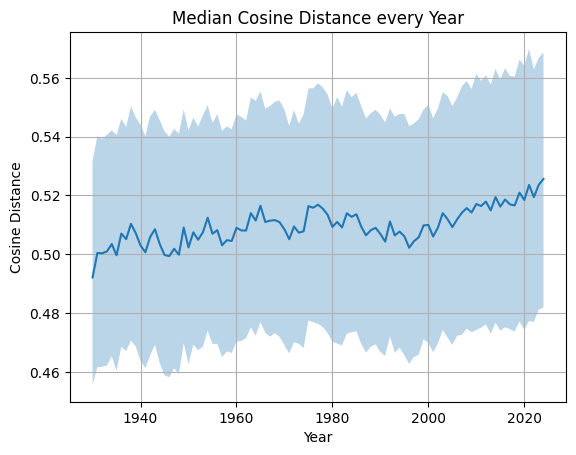

In [142]:
plt.figure()
plt.fill_between(df.year.unique().tolist(), yearly_lower_cos_dist, yearly_upper_cos_dist, alpha=0.3)
plt.plot(df.year.unique().tolist(), yearly_median_cos_dist)
plt.grid(True)
plt.title("Median Cosine Distance every Year")
plt.xlabel("Year")
plt.ylabel("Cosine Distance")
plt.show();

In [143]:
# Experiment 2: all genres (single genres)
genre_median_cos_dist = []
genre_lower = []
genre_upper = []
unique_genres = list(set([
    x
    for xs in df.new_genre.tolist()
    for x in xs
]))
for genre in tqdm(unique_genres, total=len(unique_genres)):
    genre_df = df[(df.new_genre.apply(len)==1) & (df.new_genre.apply(lambda x: genre in x))]
    # if len(genre_df) >= 10000:
    #     genre_df = genre_df.sample(10000)
    genre_embeddings = np.stack(genre_df.embedding.tolist())
    genre_pairwise = cdist(genre_embeddings, genre_embeddings, metric="cosine")
    vals = genre_pairwise[np.triu_indices_from(genre_pairwise, k=1)]
    quantiles = np.quantile(vals, q=[0.25, 0.5, 0.75])
    median = quantiles[1]
    lower = quantiles[0]
    upper = quantiles[2]
    genre_median_cos_dist.append(median)
    genre_lower.append(lower)
    genre_upper.append(upper)

100%|██████████| 19/19 [07:43<00:00, 24.39s/it]


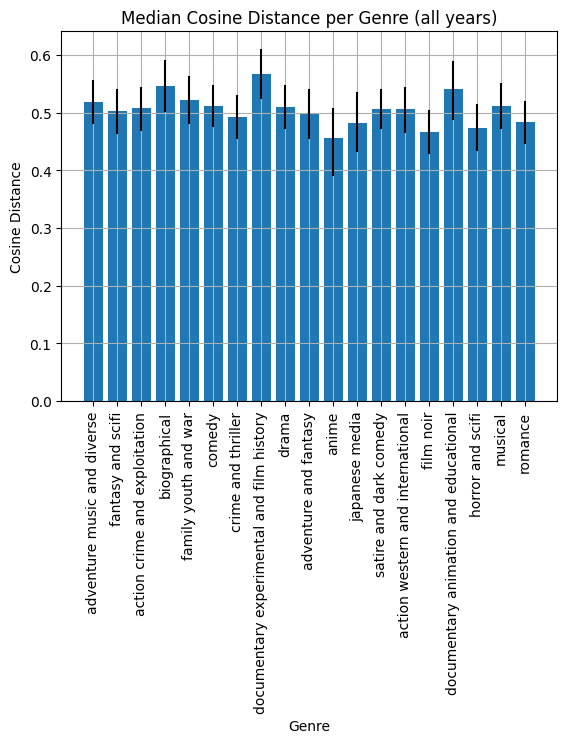

In [144]:
genre_median_cos_dist = np.array(genre_median_cos_dist)
genre_lower = np.array(genre_lower)
genre_upper = np.array(genre_upper)
yerr_lower = genre_median_cos_dist - genre_lower
yerr_upper = genre_upper - genre_median_cos_dist
yerr = np.vstack([yerr_lower, yerr_upper])

plt.figure()
plt.bar(unique_genres, genre_median_cos_dist, yerr=yerr)
plt.grid(True)
plt.title("Median Cosine Distance per Genre (all years)")
plt.xlabel("Genre")
plt.ylabel("Cosine Distance")
plt.xticks(rotation=90)
plt.show();

Below is a random example of how time does not affect cosine distances.

In [145]:
random_movie = df[df.year==2024].sample(1, random_state=8).iloc[0]
df_sample = df.sample(50000, random_state=43)
all_movie_embs = np.stack(df_sample.embedding.tolist())
cos_dist_to_random_movie = cdist(all_movie_embs, [random_movie.embedding], metric="cosine")
pair_movie_ind = np.argmin(cos_dist_to_random_movie)
pair_movie = df_sample.iloc[pair_movie_ind]
print(random_movie.year)
print(random_movie.title)
print(random_movie.new_genre)
print(random_movie["plot"])
print("___________________________________________")
print(pair_movie.year)
print(pair_movie.title)
print(pair_movie.new_genre)
print(pair_movie["plot"])

2024
Marcello Mio
['comedy']
Chiara is an actress and the daughter of Marcello Mastroianni and Catherine Deneuve. One summer, she tells herself that she should rather live her father's life. She now dresses like him, speaks like him, and imitates his physical presence, and she delivers it with such command that others around her end up believing it and begin calling her "Marcello".
___________________________________________
2024
Marcello Mio
['comedy']
Chiara is an actress and the daughter of Marcello Mastroianni and Catherine Deneuve. One summer, she tells herself that she should rather live her father's life. She now dresses like him, speaks like him, and imitates his physical presence, and she delivers it with such command that others around her end up believing it and begin calling her "Marcello".


Random thought experiment: 
Find the most average movie in 2024s, this will be our anchor movie.
1. Feature 1: cosine distane of all movies to this anchor movie.
2. Feature 2: year difference between all movies and this anchor movie.

Compare feature 1 and 2 using different correlation metrics (pearson, spearman, kendall), linear, non-linear, KL divergence, everything. 

In [146]:
from src.analysis.math_functions.cosine_distance_util import find_nearest_and_furthest_medoid

In [147]:
# Find 2024 anchor movie
movies_2024 = df[df.year==2024]
emb_2024 = np.stack(movies_2024.embedding.tolist())
anchor_movie_ind, _ = find_nearest_and_furthest_medoid(emb_2024)
anchor_movie_id = movies_2024.iloc[anchor_movie_ind]["movie_id"]

In [148]:
# Calculate cos distance from anchor movie
# First remove anchor from dataset
df_without_anchor = df[df.movie_id!=anchor_movie_id]
df_emb = np.stack(df_without_anchor.embedding.tolist())
feature1_cos_dist = cdist(df_emb, movies_2024[movies_2024.movie_id==anchor_movie_id].embedding.tolist(), metric="cosine").squeeze()

In [149]:
# Feature 2: year difference from anchor movie's year: 2024
feature2_year_diff = df_without_anchor.year.values - 2024

In [150]:
feature3_year = df_without_anchor.year.values

In [151]:
experiment_df = pd.DataFrame({"cos_dist": feature1_cos_dist, "year_diff": feature2_year_diff, "year": feature3_year})

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# df has columns: year, cos_dist

grouped = experiment_df.groupby("year")["cos_dist"]
mean = grouped.mean()
std = grouped.std()              # or use quantiles if you prefer IQR
upper = mean + 2 * std
lower = mean - 2 * std


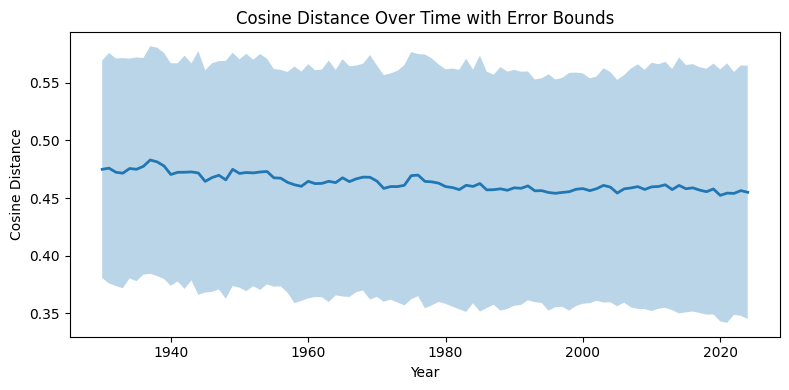

In [153]:
years = mean.index.values

plt.figure(figsize=(8,4))

# shaded region
plt.fill_between(years, lower, upper, alpha=0.3)

# mean line
plt.plot(years, mean, linewidth=2)

plt.xlabel("Year")
plt.ylabel("Cosine Distance")
plt.title("Cosine Distance Over Time with Error Bounds")

plt.tight_layout()
plt.show()


In [154]:
import pymannkendall as mk
from scipy.stats import spearmanr, kendalltau, linregress
import numpy as np

# 1. Mann-Kendall test for trend
mk_result = mk.original_test(feature1_cos_dist)
print(f"Trend: {mk_result.trend}, p-value: {mk_result.p}")

# 2. Spearman correlation for robustness
spearman_r, spearman_p = spearmanr(feature2_year_diff, feature1_cos_dist)
print(f"Spearman r: {spearman_r}, p-value: {spearman_p}")

# 3. Linear regression for slope
slope, intercept, r2, p_val, se = linregress(feature2_year_diff, feature1_cos_dist)
print(f"Slope: {slope:.6f} per year, p-value: {p_val}")


Trend: decreasing, p-value: 0.0
Spearman r: -0.10351854846234711, p-value: 1.04956171397904e-181
Slope: -0.000201 per year, p-value: 1.6763975757823829e-186
